# Tuning LoRA Hyperparameters - Identifying Baselines and Initial Hyperparameters

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append('src')

import sagemaker
from sagemaker.pytorch import PyTorch

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters,
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/77/d3_lt6bx5pz4pqbb9dyn83zc0000gr/T/tmptnveqcjp
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/77/d3_lt6bx5pz4pqbb9dyn83zc0000gr/T/tmptnveqcjp/_remote_module_non_scriptable.py


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


## Establishing Baseline Performance and Hyperparameters
Before we run any experiment with LoRA itself, let's establish a performance baseline. 

This includes finding good hyperparameters. We'll just tune learning rate and orient ourselves with weight decay and dropout on the values used in the RoBERTa and LoRA papers. We use a little higher dropout (0.15) as in the papers (0.1). Keeping these hyperparameters fixed it will isolate the impact of the architectural changes (which components to adopt, what size of the components) and hence makes it easier to follow.
We are maintaining this approach through all notebooks. But if you are replicating this approach for your task and model, consider using the best found hyperparameter values, but then also tune for weight decay and dropout. This could be helpful to get the last bit of performance and to control variance.

Back to the baselines. We could capture data for three scenarios: 
- Random Performance (not captured, not interesting enough) 
- Training of the classifier head only, using the RoBERTa layers only in a feature-extractor-fashion (expectation: lower bound of performance)
- Full finetuning (expectation: higher bound of performance)

An an side, let's find out how many parameters we have in a model, **before** we add trainable parameters for LoRA. This way we find the true 100%. Later in these notebooks we use this information to calculate how many parameters we need to train for LoRA, relative to those 100% of the original model. 

In [3]:
from transformers import AutoModelForSequenceClassification

roberta_total, roberta_learnable = count_parameters(
    AutoModelForSequenceClassification.from_pretrained('roberta-base'), 
    verbose=False
)
roberta_learnable, roberta_total

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:src.util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


(124647170, 124647170)

### Full-Finetuning Performance
#### Initial Search

In [4]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner, HyperbandStrategyConfig, StrategyConfig, TuningJobCompletionCriteriaConfig

In [5]:
fullft_estimator = PyTorch(**get_default_estimator_parameters())
fullft_estimator.set_hyperparameters(**{'sst2-lora-config': 'none'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(1e-5, 6e-5),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = fullft_estimator,
    base_tuning_job_name = 'full-finetuning',
    max_jobs = 15,
    max_parallel_jobs = 2,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}

lr_wd_tuner = HyperparameterTuner(**tuner_parameters)
lr_wd_tuner.fit(wait=False)

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: full-finetuning-230810-1443


In [6]:
clf_estimator = PyTorch(**get_default_estimator_parameters())
clf_estimator.set_hyperparameters(**{'sst2-lora-config': 'clf_only'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(3e-5, 2e-3),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = clf_estimator,
    base_tuning_job_name = 'clf-only-tuning',
    max_jobs = 15,
    max_parallel_jobs = 2,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}
lr_wd_clf_tuner = HyperparameterTuner(**tuner_parameters)
lr_wd_clf_tuner.fit(wait=False)

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: clf-only-tuning-230810-1443


### Find Initial Hyperparameters for LoRA Finetuning
We don't want to vary too many hyperparameters at the same time. Hence we fix the learning rate and weight decay. But as both hyperparameters can be significantly different for the low parameters learning regime with LoRA vs the high pararameters regime with a full finetuning, we will tune for some setting in the low parameters regime. And, maybe, at the end we will tune again with learning rate and weight decay again

In [7]:
lora_base_estimator = PyTorch(**get_default_estimator_parameters())
lora_base_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', }) 
hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(5e-5, 3e-3),
}

max_jobs = 15
tuner_parameters = {**(p('tuner_parameters') | dict(
    metric_definitions=p('metric_definitions'),
    base_tuning_job_name= 'lora-base-tuning', 
    max_jobs=max_jobs,   
    strategy= 'Bayesian',
    hyperparameter_ranges= hpt_ranges,
    max_parallel_jobs=2,
    estimator=lora_base_estimator))}

base_lora_tuner = HyperparameterTuner(**tuner_parameters)
base_lora_tuner.fit(wait=False)
base_lora_tuner_name = base_lora_tuner.describe()["HyperParameterTuningJobName"]
%store base_lora_tuner_name

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: lora-base-tuning-230810-1443
Stored 'base_lora_tuner_name' (str)


### Analysis

Let's take a look. As a quick common sense check we can see that our chosen hyperparameter has an impact on the objective metric. We can deduct that from the panels for the individual hyperparameter and that we see peaks and not just a random distribution of values that we would see if the hyperparameters had no effect. Having no effect could be caused by the hyperparameter's function not being applicable (to this task and data), the effect not being observable in the value range we specified for this hyperparameter, or because we have a mechanical problem where our hyperparameter value setting from the outside does not reach the point of impact. I see all three regularly, the third option particular often in my code during the first run. So I am happy here to see, that our hyper parameter shows an effect. 

What we are also looking for is a significant fall off on both sides. In the second example. FIXME: Rewrite with last run. 


, just on the right side (with larger learning rates). It's unlikely that a smaller learning rate will work, given that we also use a higher bs than in the original paper, but let's make sure.



FIXME: We don't see a significant fall off on both sides, just on the right side (with larger learning rates). It's unlikely that a smaller learning rate will work, given that we also use a higher bs than in the original paper, but let's make sure.

FIXME: Just just? And just just 10 runs now.

This is a one time activity that we are not going to repeat. 

As the different tuning jobs that create our baselines and base hyperparameters are not dependent on each other we do not have to wait for the individual tuning job to finish, before we start the next one. 
Hence we called `fit()` without waiting for the result and we do the waiting here in this section. So that the tuning jobs can run in parallel. 

'full-finetuning-230810-1443'

!
Tuning job full-finetuning-230810-1443 status: Completed

Number of training jobs with valid objective: 15
Lowest: 0.9334862232208252 Highest 0.9449541568756104


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
11,0.000036,full-finetuning-230810-1443-004-a0a42048,Completed,2023-08-10 16:25:09+02:00,2023-08-10 16:39:14+02:00,845.0,full-finetuning-230810-1443,0.944954
1,0.000012,full-finetuning-230810-1443-014-3315bb31,Completed,2023-08-10 19:15:07+02:00,2023-08-10 19:29:22+02:00,855.0,full-finetuning-230810-1443,0.942661
3,0.000020,full-finetuning-230810-1443-012-1d574b37,Completed,2023-08-10 18:51:56+02:00,2023-08-10 19:03:45+02:00,709.0,full-finetuning-230810-1443,0.941514
7,0.000051,full-finetuning-230810-1443-008-aff34712,Completed,2023-08-10 18:24:06+02:00,2023-08-10 18:36:56+02:00,770.0,full-finetuning-230810-1443,0.941514
5,0.000036,full-finetuning-230810-1443-010-1fa69c42,Completed,2023-08-10 18:39:46+02:00,2023-08-10 18:50:25+02:00,639.0,full-finetuning-230810-1443,0.940367
9,0.000036,full-finetuning-230810-1443-006-05f8a5be,Completed,2023-08-10 17:21:28+02:00,2023-08-10 17:32:02+02:00,634.0,full-finetuning-230810-1443,0.940367
12,0.000035,full-finetuning-230810-1443-003-9ce7ab24,Completed,2023-08-10 16:15:03+02:00,2023-08-10 16:28:08+02:00,785.0,full-finetuning-230810-1443,0.940367
13,0.000055,full-finetuning-230810-1443-002-93d4f422,Completed,2023-08-10 15:15:36+02:00,2023-08-10 15:27:19+02:00,703.0,full-finetuning-230810-1443,0.940367
2,0.000036,full-finetuning-230810-1443-013-a602935f,Completed,2023-08-10 19:14:11+02:00,2023-08-10 19:24:50+02:00,639.0,full-finetuning-230810-1443,0.939220
8,0.000036,full-finetuning-230810-1443-007-e9cfc51b,Completed,2023-08-10 17:41:28+02:00,2023-08-10 17:51:55+02:00,627.0,full-finetuning-230810-1443,0.938073


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".


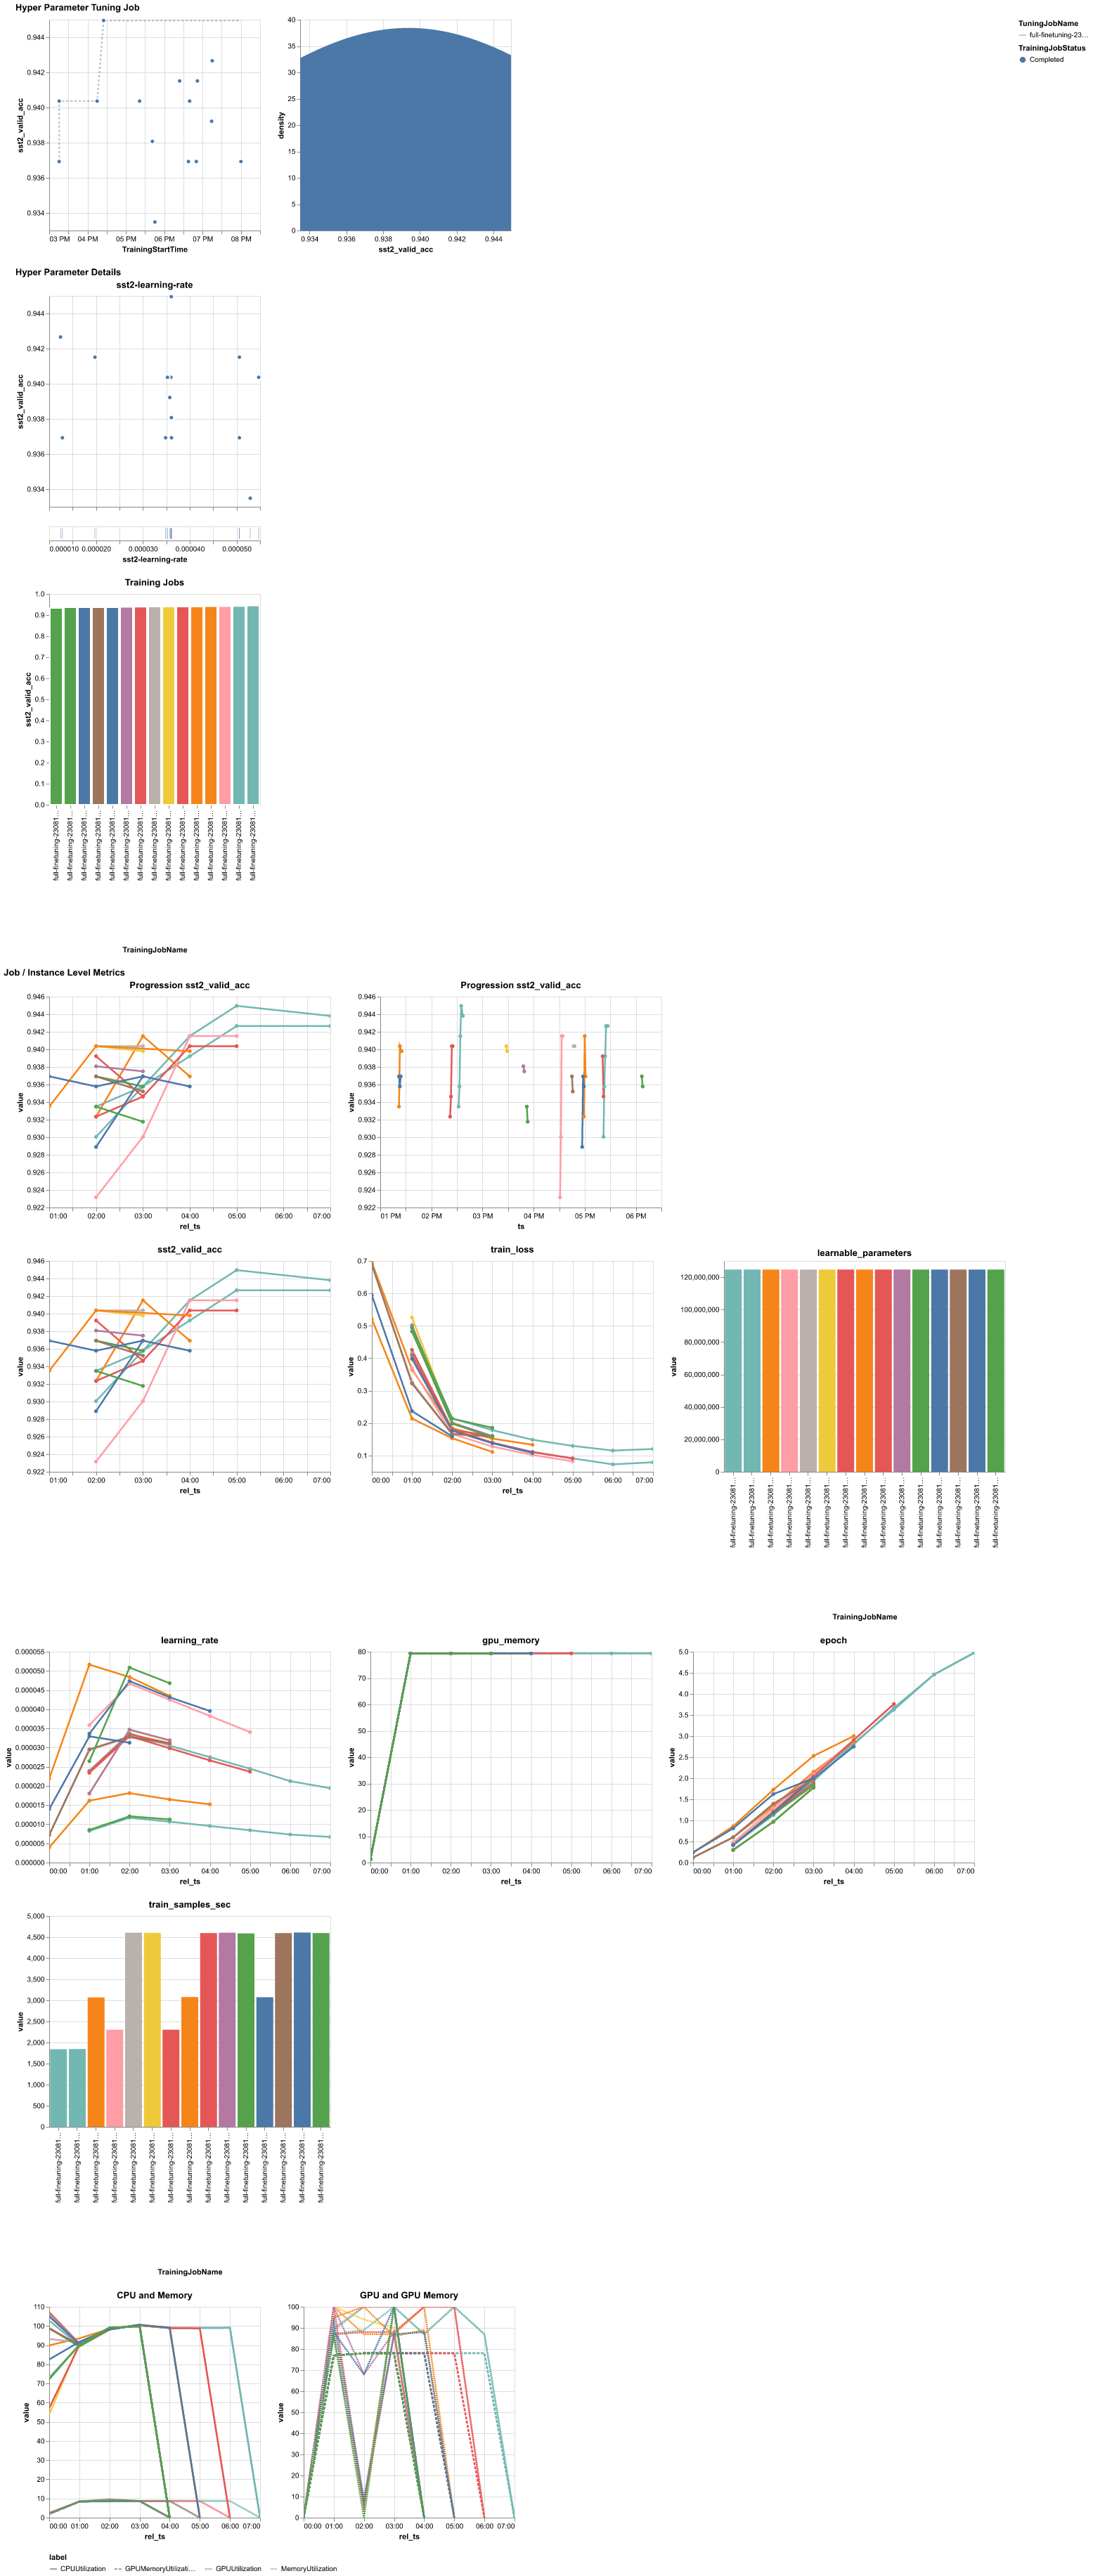

WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


'clf-only-tuning-230810-1443'

!
Tuning job clf-only-tuning-230810-1443 status: Completed

Number of training jobs with valid objective: 15
Lowest: 0.7855504751205444 Highest 0.8417431116104126


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
7,0.001668,clf-only-tuning-230810-1443-008-d0457c1f,Completed,2023-08-10 17:28:55+02:00,2023-08-10 17:40:39+02:00,704.0,clf-only-tuning-230810-1443,0.841743
2,0.001781,clf-only-tuning-230810-1443-013-83e39956,Completed,2023-08-10 18:41:16+02:00,2023-08-10 18:52:34+02:00,678.0,clf-only-tuning-230810-1443,0.839450
3,0.002000,clf-only-tuning-230810-1443-012-cd93a427,Completed,2023-08-10 18:18:53+02:00,2023-08-10 18:30:02+02:00,669.0,clf-only-tuning-230810-1443,0.838303
14,0.001536,clf-only-tuning-230810-1443-001-67e69553,Completed,2023-08-10 15:15:41+02:00,2023-08-10 15:27:25+02:00,704.0,clf-only-tuning-230810-1443,0.838303
10,0.001376,clf-only-tuning-230810-1443-005-a6c2643a,Completed,2023-08-10 16:25:15+02:00,2023-08-10 16:36:33+02:00,678.0,clf-only-tuning-230810-1443,0.834862
8,0.001495,clf-only-tuning-230810-1443-007-524e987c,Completed,2023-08-10 17:09:26+02:00,2023-08-10 17:20:39+02:00,673.0,clf-only-tuning-230810-1443,0.831422
11,0.001935,clf-only-tuning-230810-1443-004-19a69b5c,Completed,2023-08-10 16:05:34+02:00,2023-08-10 16:16:23+02:00,649.0,clf-only-tuning-230810-1443,0.830275
12,0.001244,clf-only-tuning-230810-1443-003-7512202b,Completed,2023-08-10 16:05:39+02:00,2023-08-10 16:16:28+02:00,649.0,clf-only-tuning-230810-1443,0.825688
0,0.001089,clf-only-tuning-230810-1443-015-57179a6f,Completed,2023-08-10 18:56:06+02:00,2023-08-10 19:07:00+02:00,654.0,clf-only-tuning-230810-1443,0.824541
9,0.001789,clf-only-tuning-230810-1443-006-10b0374d,Completed,2023-08-10 17:45:44+02:00,2023-08-10 17:56:37+02:00,653.0,clf-only-tuning-230810-1443,0.824541


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


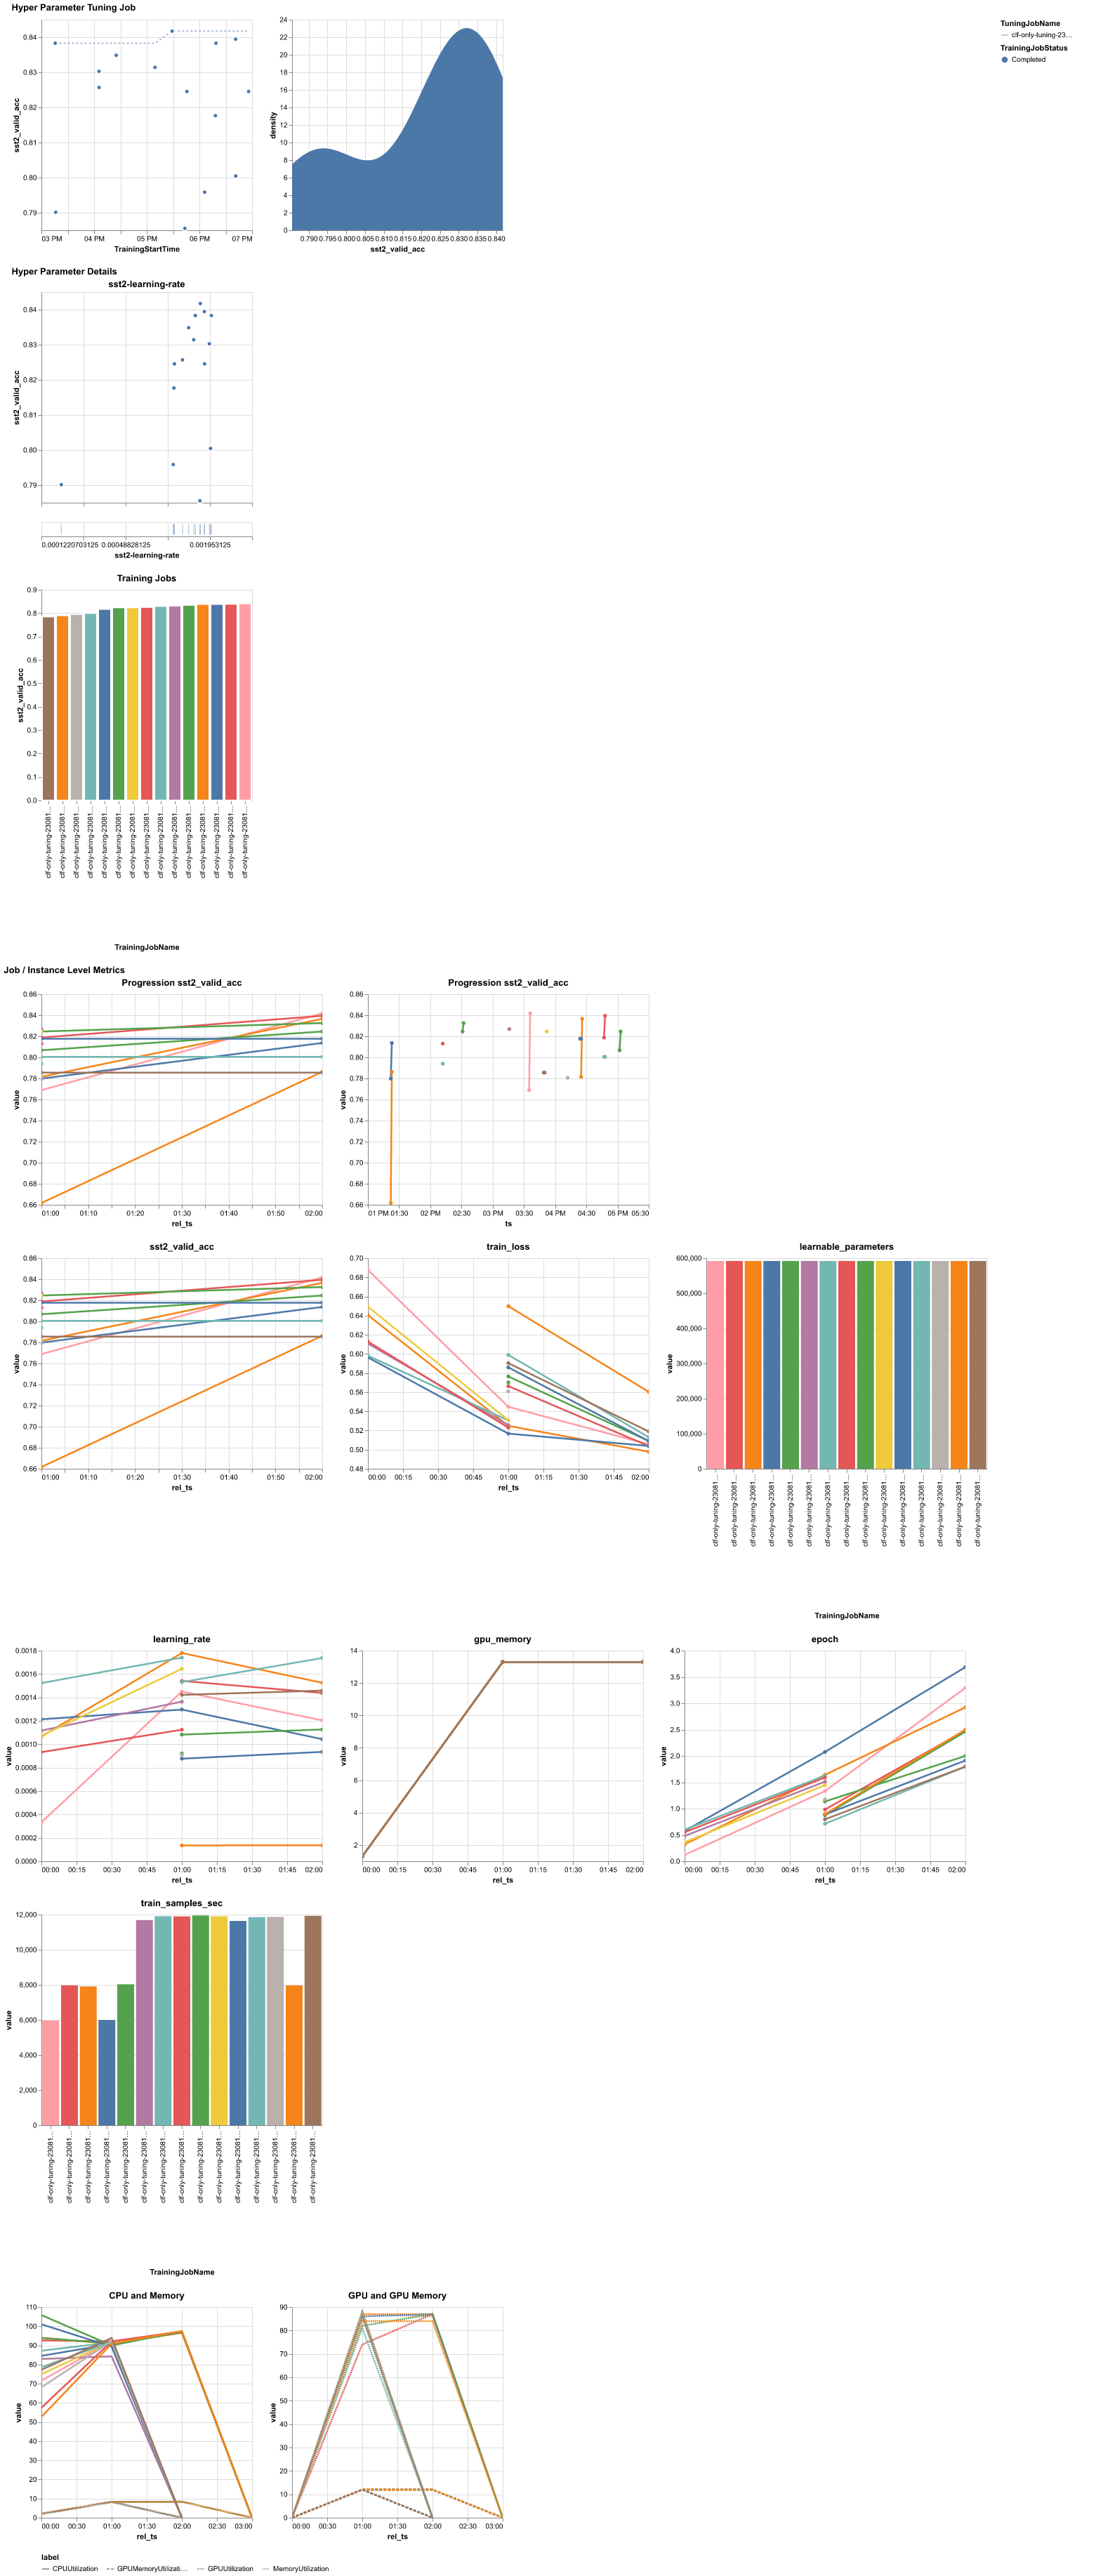

'lora-base-tuning-230810-1443'

!
Tuning job lora-base-tuning-230810-1443 status: Completed

Number of training jobs with valid objective: 15
Lowest: 0.9288991093635559 Highest 0.9495412707328796


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,0.000691,lora-base-tuning-230810-1443-014-d47af461,Completed,2023-08-10 18:38:08+02:00,2023-08-10 18:55:28+02:00,1040.0,lora-base-tuning-230810-1443,0.949541
5,0.000636,lora-base-tuning-230810-1443-010-3e47d0a3,Completed,2023-08-10 17:46:21+02:00,2023-08-10 18:01:10+02:00,889.0,lora-base-tuning-230810-1443,0.949541
10,0.000398,lora-base-tuning-230810-1443-005-336a63a9,Completed,2023-08-10 16:16:56+02:00,2023-08-10 16:34:17+02:00,1041.0,lora-base-tuning-230810-1443,0.949541
0,0.000706,lora-base-tuning-230810-1443-015-1b997331,Completed,2023-08-10 18:40:10+02:00,2023-08-10 18:58:50+02:00,1120.0,lora-base-tuning-230810-1443,0.948394
4,0.000282,lora-base-tuning-230810-1443-011-b3c6b445,Completed,2023-08-10 18:00:34+02:00,2023-08-10 18:21:25+02:00,1251.0,lora-base-tuning-230810-1443,0.948394
8,0.000716,lora-base-tuning-230810-1443-007-fb73563d,Completed,2023-08-10 16:47:01+02:00,2023-08-10 17:04:00+02:00,1019.0,lora-base-tuning-230810-1443,0.948394
7,0.000665,lora-base-tuning-230810-1443-008-c33396bf,Completed,2023-08-10 17:06:29+02:00,2023-08-10 17:22:14+02:00,945.0,lora-base-tuning-230810-1443,0.947248
3,0.000630,lora-base-tuning-230810-1443-012-c1787963,Completed,2023-08-10 18:22:47+02:00,2023-08-10 18:38:42+02:00,955.0,lora-base-tuning-230810-1443,0.946101
9,0.000545,lora-base-tuning-230810-1443-006-cbe6f0c9,Completed,2023-08-10 17:07:05+02:00,2023-08-10 17:24:05+02:00,1020.0,lora-base-tuning-230810-1443,0.946101
13,0.000894,lora-base-tuning-230810-1443-002-2071d744,Completed,2023-08-10 15:15:43+02:00,2023-08-10 15:32:43+02:00,1020.0,lora-base-tuning-230810-1443,0.946101


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


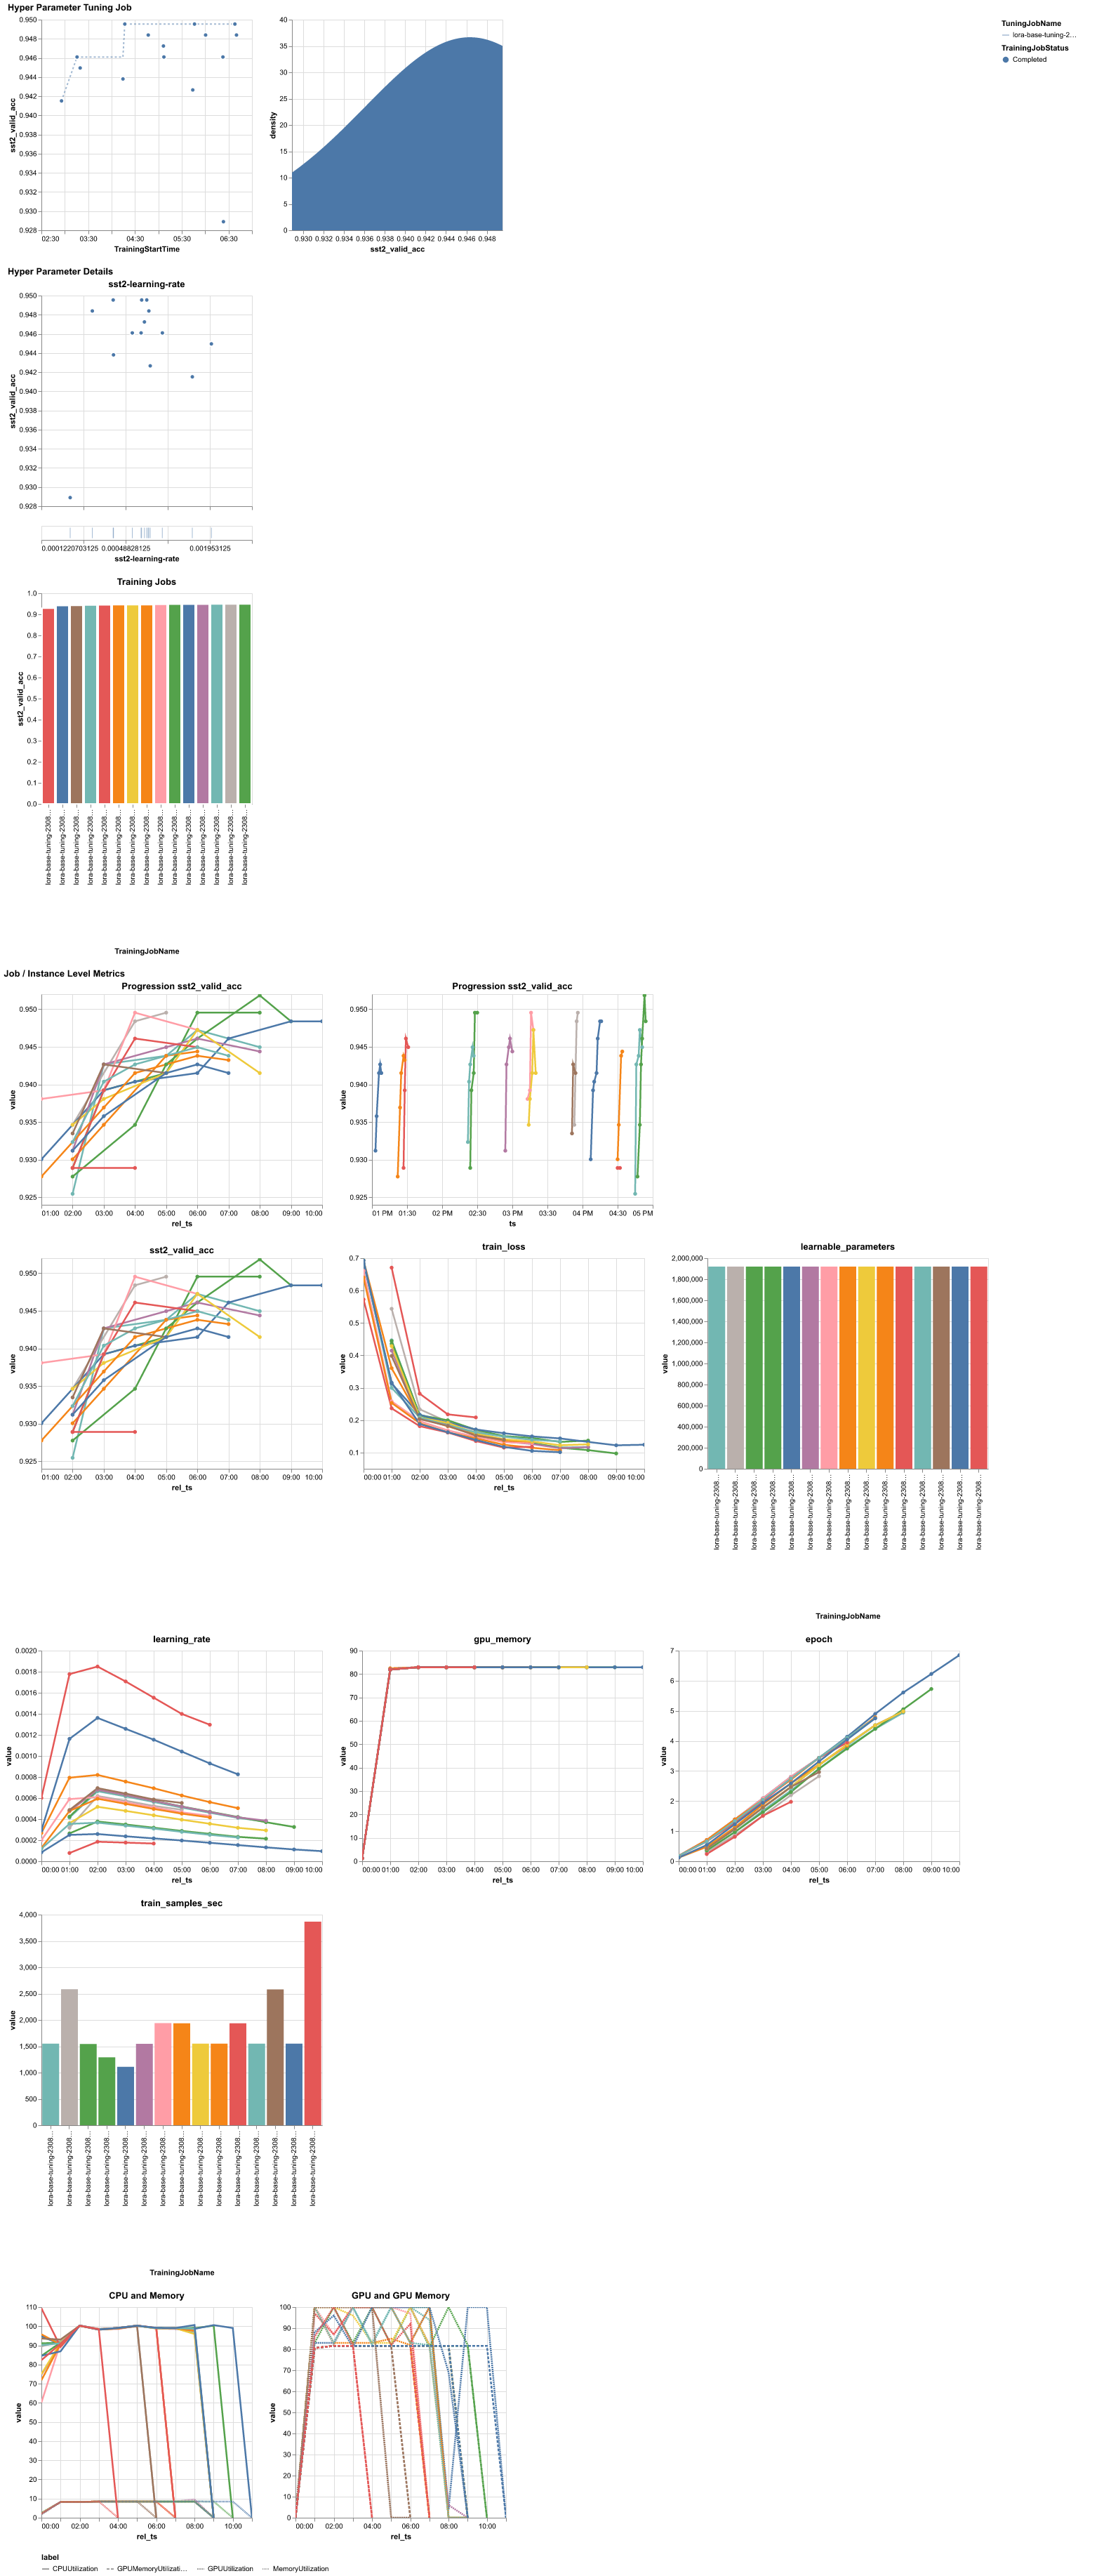

In [18]:
display_tuning_jobs([lr_wd_tuner, lr_wd_clf_tuner, base_lora_tuner])

So far so good. But now we don't want to find the best hyperparameter values, but want to sample certain combinations to judge their impact. While above we used Bayesian Optimization to search for hyperparameters, which takes the results from earlier trials to inform which hyperparameter values to pick for new trials, below we will now use a Random Search. Here we want to sample from the possible search space and don't take into account early results. 
This way we can focus on the exploration and don't bias our later trials to sample more often from the areas that are already recognized as impactful, as Bayesian Search would do, but keep sampling.

#### Capture Results

In [10]:
capture_results('Full Finetuning', fullft_estimator, lr_wd_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-230810-2012
..........................................................................................................................................................................................................!
Tuning job capture-230810-2012       status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9369266033172607 Highest 0.9529816508293152


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,2.0,capture-230810-2012-003-9d281821,Completed,2023-08-10 20:13:56+02:00,2023-08-10 20:29:15+02:00,919.0,capture-230810-2012,0.952982
1,1.0,capture-230810-2012-002-73af43e8,Completed,2023-08-10 20:13:57+02:00,2023-08-10 20:28:06+02:00,849.0,capture-230810-2012,0.950688
2,0.0,capture-230810-2012-001-043526c9,Completed,2023-08-10 20:14:18+02:00,2023-08-10 20:24:47+02:00,629.0,capture-230810-2012,0.936927


Cache Hit/Miss: MMM


In [11]:
capture_results('Classifier Only', clf_estimator, lr_wd_clf_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-230810-2030
................................................................................................................................................!
Tuning job capture-230810-2030       status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.8233944773674011 Highest 0.8302752375602722


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,0.0,capture-230810-2030-001-f6e43e3b,Completed,2023-08-10 20:31:38+02:00,2023-08-10 20:42:31+02:00,653.0,capture-230810-2030,0.830275
1,2.0,capture-230810-2030-002-2ddb349a,Completed,2023-08-10 20:31:36+02:00,2023-08-10 20:42:24+02:00,648.0,capture-230810-2030,0.827982
0,3.0,capture-230810-2030-003-f6c4efc0,Completed,2023-08-10 20:31:43+02:00,2023-08-10 20:42:31+02:00,648.0,capture-230810-2030,0.823394


Cache Hit/Miss: MMM


In [12]:
capture_results('LoRA Base', lora_base_estimator, base_lora_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-230810-2042
...........................................................................................................................................................................................................!
Tuning job capture-230810-2042       status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9403669834136963 Highest 0.9449541568756104


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,2.0,capture-230810-2042-003-d883c5cc,Completed,2023-08-10 20:44:08+02:00,2023-08-10 20:59:53+02:00,945.0,capture-230810-2042,0.944954
2,0.0,capture-230810-2042-001-ee057e02,Completed,2023-08-10 20:44:09+02:00,2023-08-10 20:59:49+02:00,940.0,capture-230810-2042,0.942661
1,1.0,capture-230810-2042-002-12cdf689,Completed,2023-08-10 20:44:09+02:00,2023-08-10 20:59:54+02:00,945.0,capture-230810-2042,0.940367


Cache Hit/Miss: MMM


In [13]:
lora_paper_estimator = PyTorch(**get_default_estimator_parameters())
lora_paper_estimator.set_hyperparameters(**{
    'sst2-lora-r': 8, 
    'sst2-lora-config': 'query|value', 
    'patience': 1,
    'sst2-batch-size': 16*8,
    'sst2-learning-rate': 5e-4,
    'sst2-weight-decay': 0.1,
    'ss2-lora-dropout': 0.05, 
    'sst2-epochs': 10} ) # 60 in the paper, 10 in the script
capture_results('LoRA Paper', lora_paper_estimator) 
# bs 16 is from the paper, but not efficient for an A10G. The script also points to 16 per one of their 8 GPUs. 
# Did not find dropout for SST-2 RoBERTa base in the paper. Using 0.1 given that we have 60 (10?) epochs.
# The paper specified alpha of 8 for r=8, but the sst2 script shows alpha of 16. Also, 60 epochs from the paper is then 10 epochs in the script.
# Tried with and without alpha, but removed alpha for simplicity, after seeing it has no original impact, and we are tuning lr anyway.
# https://github.com/microsoft/LoRA/blob/main/examples/NLU/roberta_large_sst2.sh
# -> Could not reproduce. Neither the performance, nor even creating the original environment.

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-230810-2100
.......................................................................................................................................................................................................................................................................................................................................................!
Tuning job capture-230810-2100       status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9369266033172607 Highest 0.9415137767791748


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,2.0,capture-230810-2100-002-87c72bf4,Completed,2023-08-10 21:11:50+02:00,2023-08-10 21:24:54+02:00,784.0,capture-230810-2100,0.941514
2,0.0,capture-230810-2100-001-e34b00b0,Completed,2023-08-10 21:11:55+02:00,2023-08-10 21:24:54+02:00,779.0,capture-230810-2100,0.940367
0,3.0,capture-230810-2100-003-4c1a6c3a,Completed,2023-08-10 21:12:29+02:00,2023-08-10 21:25:33+02:00,784.0,capture-230810-2100,0.936927


Cache Hit/Miss: MMM


In [14]:
graph_results()

,target_tuner_name,title,objective_metric_mean,objective_metric_std,parameters_relative,train_speed_median,gpu_memory_max
0,capture-230810-2012,Full Finetuning,0.946865,0.008683,100.000000,1841.949,79.4
1,capture-230810-2030,Classifier Only,0.827217,0.003504,0.475045,11877.474,13.3
2,capture-230810-2042,LoRA Base,0.942661,0.002294,1.539733,1937.174,82.9
3,capture-230810-2100,LoRA Paper,0.939602,0.002387,0.711642,3610.229,24.0


alt.HConcatChart(...)